In [1]:
# Add this at the beginning of your notebook
!pip install -q kagglehub transformers torch torchvision pillow matplotlib pandas tqdm

# Mount Google Drive for saving checkpoints
from google.colab import drive
drive.mount('/content/drive')

# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda


In [2]:
import kagglehub
import os

# Download the dataset (only need to do this once)
dataset_path = kagglehub.dataset_download('adityajn105/flickr8k')
print(f"Dataset path: {dataset_path}")

# Define your paths
image_dir = os.path.join(dataset_path, "Images")
caption_path = os.path.join(dataset_path, "captions.txt")

100%|██████████| 1.04G/1.04G [00:11<00:00, 97.3MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [8]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Load captions more efficiently
captions_df = pd.read_csv(caption_path)
image_captions = {}

# Get captions organized by image
for _, row in captions_df.iterrows():
    img_name, caption = row[captions_df.columns[0]], row[captions_df.columns[1]]
    if img_name not in image_captions:
        image_captions[img_name] = []
    image_captions[img_name].append(caption)

# Custom dataset with on-the-fly processing
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_captions, feature_extractor, tokenizer, max_length=50):
        self.image_dir = image_dir
        # Create image-caption pairs for training
        self.samples = []
        for img_name, captions in image_captions.items():
            for caption in captions:
                self.samples.append((img_name, caption))

        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load and process image on-the-fly
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Process caption
        tokenized = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": pixel_values,
            "labels": tokenized.input_ids.squeeze(0),
            "attention_mask": tokenized.attention_mask.squeeze(0)
        }

In [9]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# Load tokenizer and image processor
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Initialize model (smaller variant to fit in memory)
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [11]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import shutil

# Modified training loop with efficient checkpointing
def train_model():
    # Prepare dataset and dataloader (add collate_fn)
    def collate_fn(batch):
        return {
            'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.stack([x['labels'] for x in batch]),
            'attention_mask': torch.stack([x['attention_mask'] for x in batch])
        }

    dataset = Flickr8kDataset(image_dir, image_captions, feature_extractor, tokenizer)
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    # Training setup
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 3
    checkpoint_dir = "/content/drive/MyDrive/image_captioning_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Checkpoint management
    max_checkpoints = 2  # Keep only last 2 checkpoints
    checkpoint_prefix = "checkpoint_"

    def save_checkpoint(epoch, step, is_full=False):
        """Save checkpoint with rotation"""
        checkpoint_name = f"{'full' if is_full else 'step'}_epoch{epoch}_step{step}.pt"
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

        # Save full state for epoch checkpoints, minimal for steps
        if is_full:
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, checkpoint_path)
        else:
            # Lightweight checkpoint (model only)
            torch.save({'model': model.state_dict()}, checkpoint_path)

        # Remove old checkpoints
        checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith(checkpoint_prefix)])
        while len(checkpoints) > max_checkpoints:
            os.remove(os.path.join(checkpoint_dir, checkpoints[0]))
            checkpoints = checkpoints[1:]

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for step, batch in enumerate(progress_bar):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

            # Save lightweight checkpoint every 500 steps
            if (step + 1) % 500 == 0:
                save_checkpoint(epoch+1, step+1)

        # Save full checkpoint at end of epoch
        save_checkpoint(epoch+1, "final", is_full=True)

        # Print epoch statistics
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

    # Final save
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, "final_model.pt"))

# Start training
train_model()

Epoch 1/3:   0%|          | 0/5057 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Epoch 1 completed. Avg Loss: 0.5946


Epoch 2/3:   0%|          | 0/5057 [00:00<?, ?it/s]

Epoch 2 completed. Avg Loss: 0.5018


Epoch 3/3:   0%|          | 0/5057 [00:00<?, ?it/s]

Epoch 3 completed. Avg Loss: 0.4422


In [12]:
!pip install -q sacrebleu
from torch.utils.data import DataLoader
import sacrebleu
import numpy as np
from tqdm.notebook import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.4 MB/s eta 0:00:00


In [13]:
def generate_caption(image_path, model, tokenizer, feature_extractor, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        output = model.generate(pixel_values, max_length=50, num_beams=4)
        caption = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"Generated Caption: {caption}")
    return caption


In [14]:
test_image_path = os.path.join(image_dir, '667626_18933d713e.jpg')
generate_caption(test_image_path, model, tokenizer, feature_extractor, device)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Caption: A girl in a red swimsuit is laying on her back in the sand .


'A girl in a red swimsuit is laying on her back in the sand .'

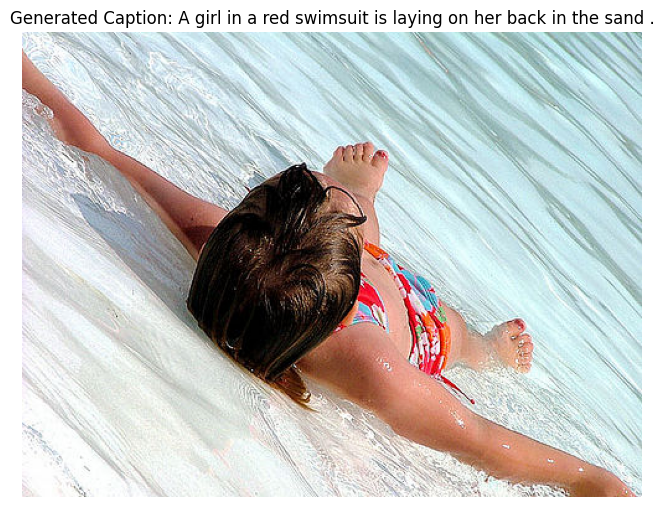

In [15]:
import matplotlib.pyplot as plt

def generate_and_display_caption(image_path, model, tokenizer, feature_extractor, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        output = model.generate(pixel_values, max_length=50, num_beams=4)
        caption = tokenizer.decode(output[0], skip_special_tokens=True)

    # Display image with caption
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated Caption: {caption}", fontsize=12, wrap=True)
    plt.show()

# Test with an example image
test_image_path = os.path.join(image_dir, '667626_18933d713e.jpg')
generate_and_display_caption(test_image_path, model, tokenizer, feature_extractor, device)


In [1]:
import random
import matplotlib.pyplot as plt

def generate_and_display_multiple_captions(image_dir, model, tokenizer, feature_extractor, device, num_images=3):
    model.eval()
    image_files = os.listdir(image_dir)
    selected_images = random.sample(image_files, num_images)

    plt.figure(figsize=(12, 8))

    for i, img_name in enumerate(selected_images):
        image_path = os.path.join(image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

        with torch.no_grad():
            output = model.generate(pixel_values, max_length=50, num_beams=4)
            caption = tokenizer.decode(output[0], skip_special_tokens=True)

        # Plot the image with caption
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Caption:\n{caption}", fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()

# Generate and display captions for 3 random images
generate_and_display_multiple_captions(image_dir, model, tokenizer, feature_extractor, device)


NameError: name 'image_dir' is not defined

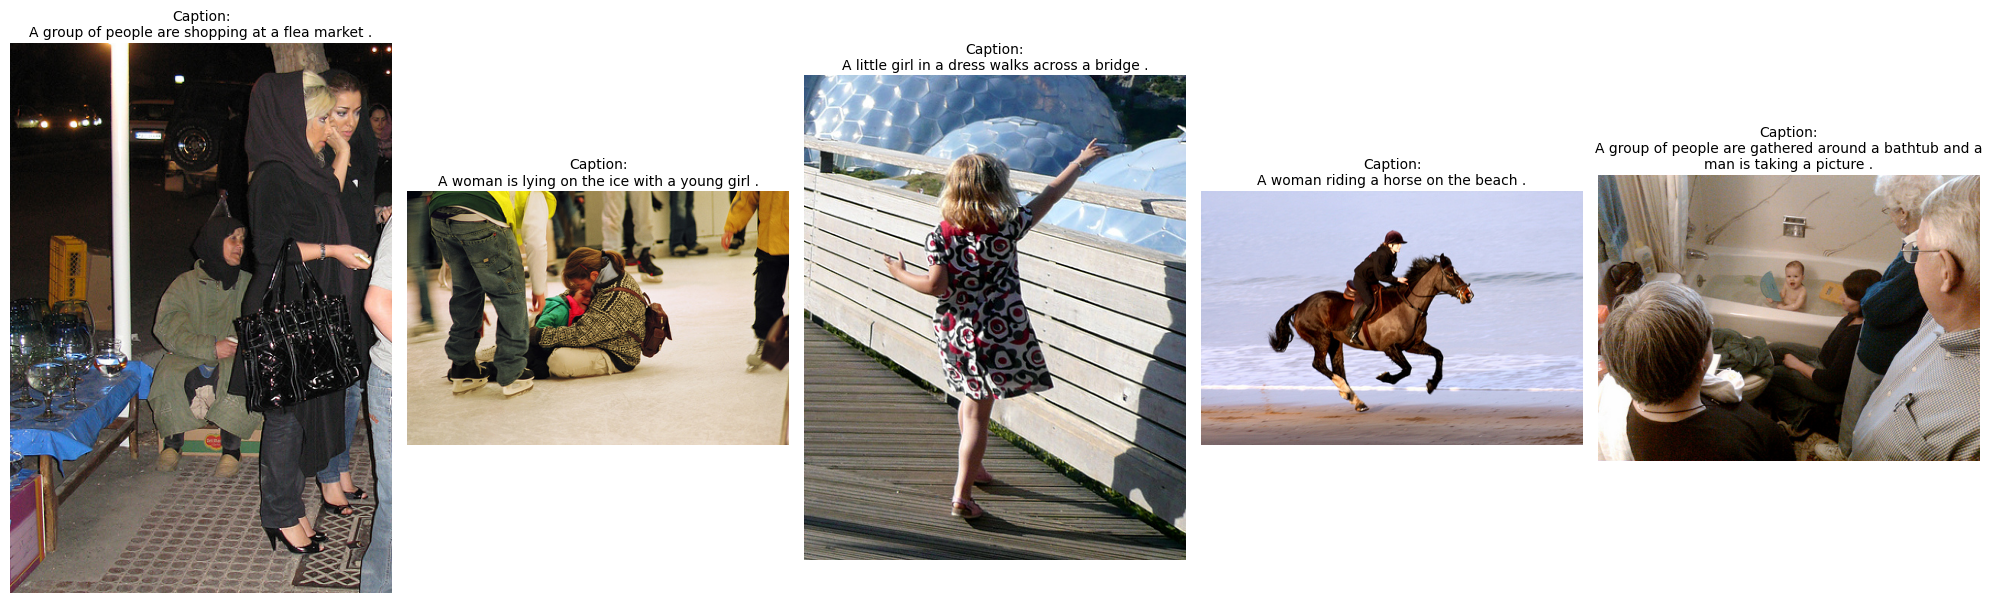

In [17]:
import random
import matplotlib.pyplot as plt

def generate_and_display_multiple_captions(image_dir, model, tokenizer, feature_extractor, device, num_images=5):
    model.eval()
    image_files = os.listdir(image_dir)
    selected_images = random.sample(image_files, num_images)

    plt.figure(figsize=(20, 10))

    for i, img_name in enumerate(selected_images):
        image_path = os.path.join(image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

        with torch.no_grad():
            output = model.generate(pixel_values, max_length=50, num_beams=4)
            caption = tokenizer.decode(output[0], skip_special_tokens=True)

        # Plot the image with caption
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Caption:\n{caption}", fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()

# Generate and display captions for 5 random images
generate_and_display_multiple_captions(image_dir, model, tokenizer, feature_extractor, device)


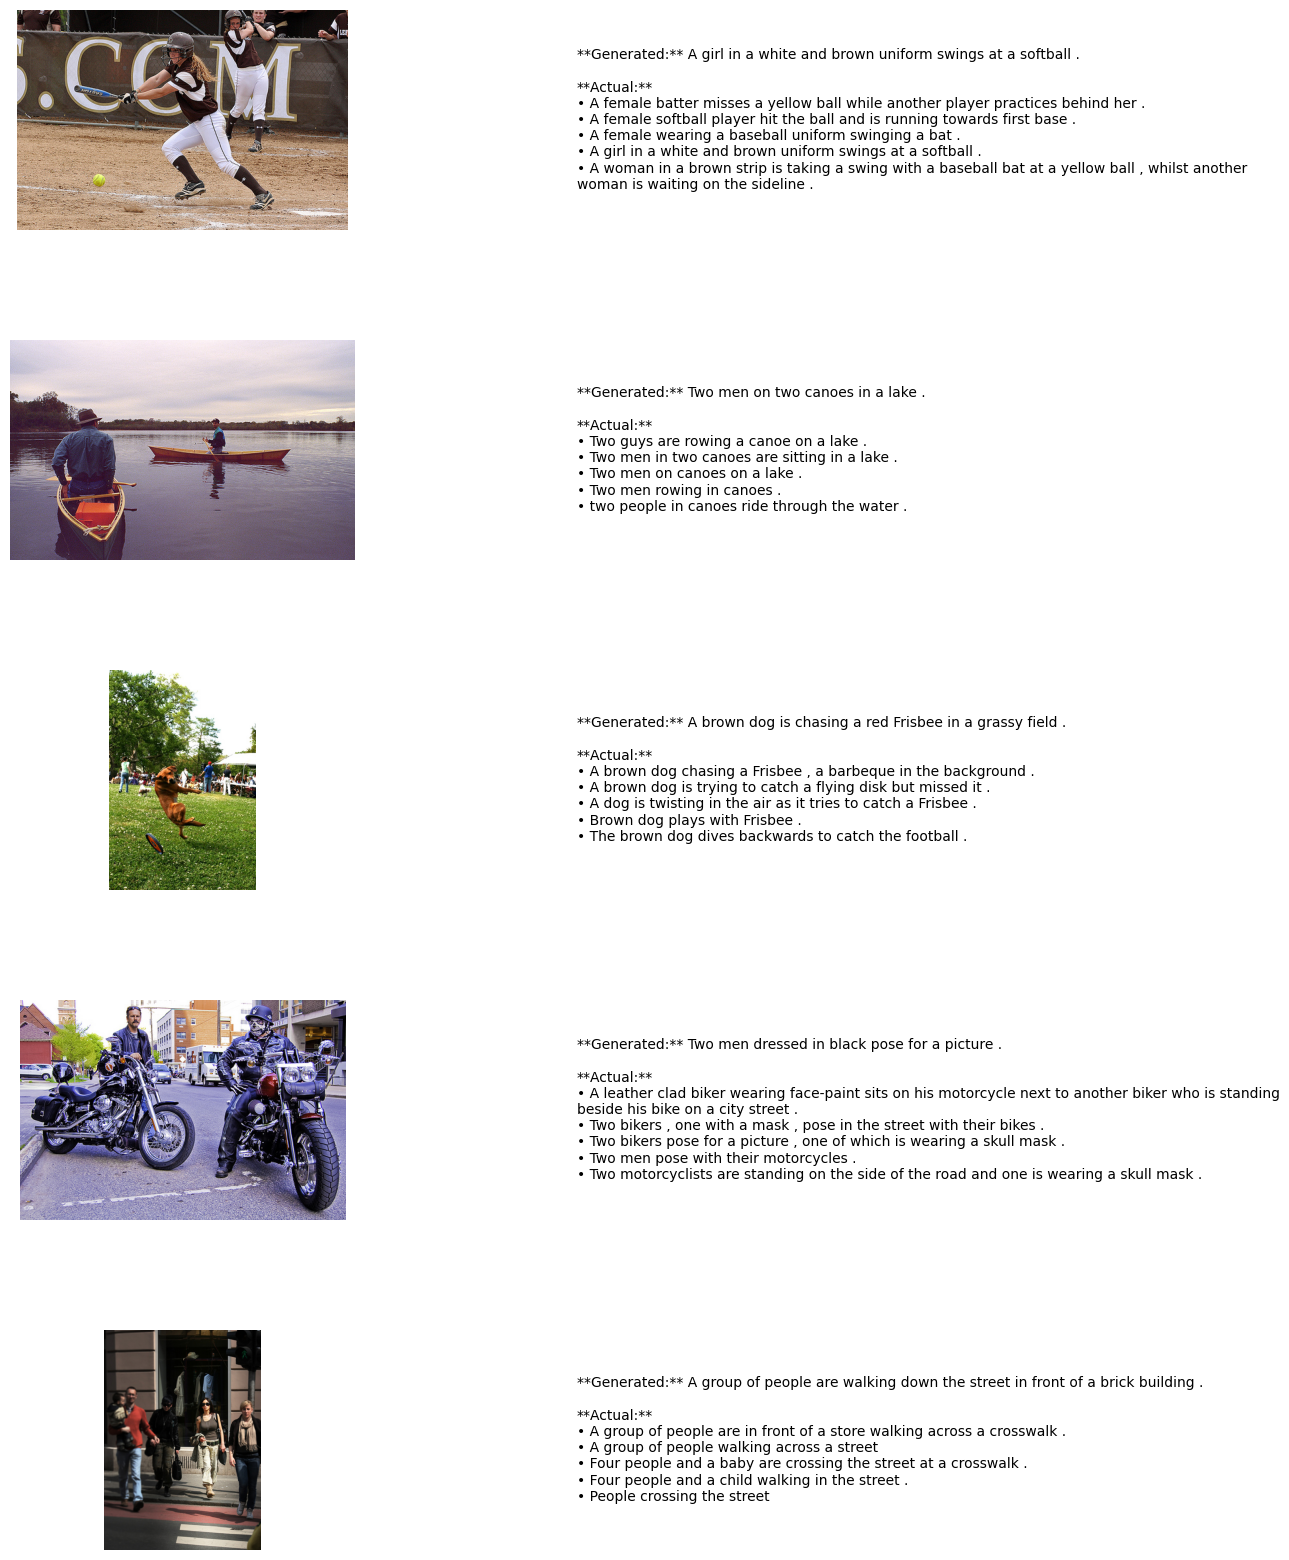

In [19]:
import random
import matplotlib.pyplot as plt

def generate_and_display_captions_with_actuals(image_dir, image_captions, model, tokenizer, feature_extractor, device, num_images=5):
    model.eval()
    image_files = list(image_captions.keys())
    selected_images = random.sample(image_files, num_images)

    fig, axs = plt.subplots(num_images, 2, figsize=(16, 4 * num_images))
    plt.subplots_adjust(hspace=0.5)

    for i, img_name in enumerate(selected_images):
        image_path = os.path.join(image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

        # Generate caption
        with torch.no_grad():
            output = model.generate(pixel_values, max_length=50, num_beams=4)
            generated_caption = tokenizer.decode(output[0], skip_special_tokens=True)

        # Get actual captions
        actual_captions = image_captions[img_name]
        actual_caption_text = "\n".join([f"• {cap}" for cap in actual_captions])

        # Plot image
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')

        # Display Captions
        caption_text = f"**Generated:** {generated_caption}\n\n**Actual:**\n{actual_caption_text}"
        axs[i, 1].text(0, 0.5, caption_text, fontsize=10, va='center', ha='left', wrap=True)
        axs[i, 1].axis('off')

    plt.show()

# Generate and display 5 random images with actual and generated captions
generate_and_display_captions_with_actuals(image_dir, image_captions, model, tokenizer, feature_extractor, device)


In [24]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(model, dataset, tokenizer, device, batch_size=8):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    total_bleu_score = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Evaluating")

    with torch.no_grad():
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Generate captions using the model
            outputs = model.generate(pixel_values, max_length=50, num_beams=4)
            predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

            # Convert labels to actual text for BLEU Score
            actual_texts = []
            for label in labels:
                actual_text = tokenizer.decode([token for token in label if token != tokenizer.pad_token_id], skip_special_tokens=True)
                actual_texts.append(actual_text)

            # Calculate BLEU Score
            for pred, actual in zip(predictions, actual_texts):
                bleu_score = sentence_bleu([actual.split()], pred.split())
                total_bleu_score += bleu_score
                total_samples += 1

    # Calculate average BLEU score
    avg_bleu_score = total_bleu_score / total_samples
    print(f"Average BLEU Score: {avg_bleu_score:.2f}")
    return avg_bleu_score


In [ ]:
dataset = Flickr8kDataset(image_dir, image_captions, feature_extractor, tokenizer)
evaluate_model(model, dataset, tokenizer, device)


Evaluating:   0%|          | 0/5057 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_model(model, dataset, tokenizer, device, batch_size=8):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    total_bleu_score = 0
    total_samples = 0
    smoother = SmoothingFunction().method1

    progress_bar = tqdm(dataloader, desc="Evaluating")

    with torch.no_grad():
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Generate captions using the model
            outputs = model.generate(pixel_values, max_length=50, num_beams=4)
            predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

            # Convert labels to actual text for BLEU Score
            actual_texts = []
            for label in labels:
                actual_text = tokenizer.decode([token for token in label if token != tokenizer.pad_token_id], skip_special_tokens=True)
                actual_texts.append(actual_text)

            # Calculate BLEU Score with smoothing
            for pred, actual in zip(predictions, actual_texts):
                bleu_score = sentence_bleu([actual.split()], pred.split(), smoothing_function=smoother)
                total_bleu_score += bleu_score
                total_samples += 1

    # Calculate average BLEU score
    avg_bleu_score = total_bleu_score / total_samples
    print(f"Average BLEU Score: {avg_bleu_score:.2f}")
    return avg_bleu_score


In [ ]:
evaluate_model(model, dataset, tokenizer, device)
